In [4]:
import sys
from mcap_protobuf.decoder import DecoderFactory
from mcap.reader import make_reader
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import geopandas as gpd
from shapely.geometry import MultiPolygon, LineString, Polygon, Point
import numpy as np
import math
import tqdm
import pickle
import ray


In [5]:
map = gpd.read_file('/home/kuribayashi-a/Documents/map/kobe.gpkg')

/home/kuribayashi-a/Source/apollo/modules/planning/tools/prediction/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'kobe.gpkg': 'lane' (default), 'central_curve', 'left_boundary', 'right_boundary', 'division'. Specify layer parameter to avoid this warning.
  result = read_func(


In [6]:
with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact.pkl", mode='rb') as f:
    prediction_data = pickle.load(f)
    # prediction_data[id]["path"] << [(x,y,v),(x,y,v)...]
    #                    ["path_lane_id"] << [traj1[id, id], traj2] 
    #                    ["prob"] << [traj1_prob, traj2_prob]
    #                    ["pred"] << [traj1[(x,y,v),(x,y,v)...], traj2]
    #                    ["pred_lane_id"] << [traj1[id, id], traj2]      


with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact_result.pkl", mode='rb') as f:
    result = pickle.load(f)
    # result = DataFrame[
                # "id", 
                # "t", 
                # "horizon", 
                # "is_lane_change", 
                # "is_branch", 
                # "scenario", 
                # "pred_lane_change", 
                # "prob", 
                # "is_selected", 
                # "ADE_lat", 
                # "ADE_long", 
                # "ADE_speed", 
                # "FDE_lat", 
                # "FDE_long", 
                # "FDE_speed"
                # ]

with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact_lane_prediction.pkl", mode='rb') as f:
    lane_prediction_df = pickle.load(f)
        #     lane_prediciton_df = DataFrame[
        #     "id",
        #     "horizon",
        #     "scenario",
        #     "is_selected",
        #     "prob",
        #     "acc",
        #     "TP",
        #     "TN",
        #     "FP",
        #     "FN",
        #     "num",
        # ]

In [53]:
# geometries = gpd.GeoSeries(MultiPolygon(map.geometry))
# geometries.plot(cmap="jet")
# plt.show()
# gpd.GeoSeries(map.geometry[0]).plot()
map
map.iloc[int(np.where(map.lane_id=="5130010000000587772")[0][0])].successor_id

,lane_id,left_neighbor_lane_id,right_neighbor_lane_id,successor_id,predecessor_id,is_transition_lane,distance_to_merge,branch_direction,length,lc_dis,lc_direction,lc_type,blinker_type,is_jct,jct_target_speed_mps,mg_anticipation_dis,is_mg_anticipation,is_mg_caution,geometry
0,5130010000002096109,5130010000002096094,5130010000002096108,5130010000002096084,5130010000002096111,False,0.0,UNKNOWN,14.39,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((362737.91 3930741.051 102.61, 3627..."
1,5130010000001449540,5130010000001449541,,5130010000001374567,5130010000001449545,False,0.0,UNKNOWN,79.68,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((92720.646 3886084.34 100.156, 9272..."
2,5130010000000541281,,5130010000000541278,5130010000000541300,5130010000000541280,False,0.0,UNKNOWN,79.50,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((13514.576 3874866.76 80.386, 13517..."
3,5130010000000522469,,5130010000000522466,5130010000000522468,5130010000000522470,False,0.0,UNKNOWN,79.88,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((158641.898 3867043.672 149.489, 15..."
4,5130010000001449541,,5130010000001449540,5130010000001374566,5130010000001449548,False,0.0,UNKNOWN,79.71,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((92719.992 3886087.907 100.046, 927..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70698,5130010000000065560,5130010000000065567,,5130010000000065559,5130010000000083126,False,0.0,UNKNOWN,67.94,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((-45031.147 3850442.528 86.84, -450..."
70699,5130010000000065567,5130010000000065563,5130010000000065560,5130010000000065561,5130010000000083124,False,0.0,UNKNOWN,67.91,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((-45032.635 3850446.081 86.763, -45..."
70700,5130010000000065566,5130010000000065565,,5130010000000083125,5130010000000065574,False,0.0,UNKNOWN,91.88,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((-44835.498 3850470.459 90.491, -44..."
70701,5130010000000065565,5130010000000083133,5130010000000065566,5130010000000083134,5130010000000065585,False,0.0,UNKNOWN,91.93,0.0,NO_CHANGE,LC_DEFAULT,NO_BLINKER,False,0.0,0.0,False,False,"POLYGON Z ((-44834.032 3850466.989 90.411, -44..."


In [57]:
prediction_data = {}
is_auto = False
ego_pose = [0.0, 0.0, 0.0]
with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact.mcap", "rb") as f:
    reader = make_reader(f, decoder_factories=[DecoderFactory()])
    for schema, channel, message, proto_msg in tqdm.tqdm(reader.iter_decoded_messages()):
        if channel.topic == "/apollo/canbus/chassis":
            is_auto = proto_msg.driving_mode

        if channel.topic == "/apollo/localization":
            ego_pose = [proto_msg.pose.position.x, 
                        proto_msg.pose.position.y, 
                        (proto_msg.pose.linear_velocity.x**2+proto_msg.pose.linear_velocity.y**2)**0.5]
    
        if channel.topic == "/apollo/prediction" and is_auto:
            for obstacle in proto_msg.prediction_obstacle:
                feature = obstacle.feature[0]
                id = feature.id
                curr_lane_ids = []
                curr_position = []
                
                # Current lane 
                curr_lane_ids = [lane_feature.lane_id for lane_feature in feature.lane.current_lane_feature]
                # Current position
                curr_position = [feature.position.x, feature.position.y, feature.speed]
                list_pred_lane_ids = []
                list_pred_traj = []
                probs = []
                for traj in feature.predicted_trajectory:
                    pred_lane_ids = [curr_lane_ids] # t0 of the predicted lane is target lane, not current lane.
                                                    # Predicted lane sequence always stayes in the connected lane sequences
                                                    # It's impossible to judge wheter lane change happens in the predicted sequence.
                                                    # Therefore, add current lane id as t0 to be able to judge lane change in the sequence 
                    pred_traj = [curr_position]
                    for point in traj.trajectory_point:
                        pred_lane_ids.append([point.path_point.lane_id])
                        pred_traj.append([point.path_point.x,
                                          point.path_point.y,
                                          point.v])
                    probs.append(traj.probability)
                    list_pred_lane_ids.append(pred_lane_ids)
                    list_pred_traj.append(pred_traj)

                # try:
                #     if len(list_pred_lane_ids) > 1 and is_lane_change(prediction_data[id]["path"], map):
                #         print(id, not is_branch(prediction_data[id]["path"], map),  is_lane_change(list_pred_lane_ids[0], map),
                #               is_lane_change(list_pred_lane_ids[1], map))
                # except:
                #     pass
                
                if id not in prediction_data.keys():
                    prediction_data[id] = {"path": [],
                                           "path_lane_id": [],
                                           "prob": [],
                                           "pred": [],
                                           "pred_lane_id": [],
                                           "ego_pose": []}
    
                prediction_data[id]["path"].append(curr_position)
                prediction_data[id]["path_lane_id"].append(curr_lane_ids)
                prediction_data[id]["prob"].append(probs)
                prediction_data[id]["pred"].append(list_pred_traj)
                prediction_data[id]["pred_lane_id"].append(list_pred_lane_ids)
                prediction_data[id]["ego_pose"].append(ego_pose)

# prediction_data[2727]["path_lane_id"]

1391559it [00:32, 42460.84it/s]


In [53]:
def is_lane_change(path_lane_ids, map):
    # print(path_lane_ids)
    for i in range(0, len(path_lane_ids)-1):
        if path_lane_ids[i] == path_lane_ids[i+1]: continue
        if len(path_lane_ids[i+1]) == 0 or len(path_lane_ids[i]) == 0: continue

        # check that the vehicle keeps lane
        keep_lane = False
        # print("-"*10)
        for path_id in path_lane_ids[i]:
            index_of_lane_id = np.where(map.lane_id==str(path_id))
            if len(index_of_lane_id[0]) == 0:
                # print(f"{path_id} not exist in map")
                continue
            successor_id = map.iloc[int(index_of_lane_id[0][0])].successor_id
      
            # print(path_lane_ids[i], path_lane_ids[i+1], successor_id, successor_id in path_lane_ids[i+1]) 
            if successor_id in path_lane_ids[i+1]:
                keep_lane = True
                break
        
        if not keep_lane:
            return True
    
    return False

# for id, item in prediction_data.items():
#     prediction_data[id]["is_lane_change"] = is_lane_change(item["path_lane_id"], map)
# is_lane_change(prediction_data[2727]["path_lane_id"], map)
# is_lane_change(prediction_data[2727]["pred_lane_id"][0][0:20], map)

In [54]:
def is_branch(path_lane_ids, map):
    for path_lane_id in path_lane_ids:
        if len(path_lane_id) > 1:
            return True
    return False

# is_lane_change(prediction_data[2727]["path_lane_id"], map)
# for id, item in prediction_data.items():
#     prediction_data[id]["is_branch"] = is_branch(item["path_lane_id"], map)

In [6]:
# def check_lane_prediction(path_lane_id, pred_lane_id, t, horizon):
#     """
#     path_lane_id: lane that the vehicle passed through
#     pred_lane_id: predicted lane at time t
#     """
#     # if horizon is too long, stop validation
#     if horizon >= len(pred_lane_id[t]) or t+horizon >= len(path_lane_id): 
#         return None

#     # Check the whole prediction from 0 to horizon
#     for h in range(0, horizon):
#         # Check that the predicted_lane_id is in the path_lane_id at time t(start_time)+h(prediction horizon) 
#         is_prediction_correct = pred_lane_id[t][h] in path_lane_id[t+h] 
#         if not is_prediction_correct: 
#             return False

#     return True

# print(prediction_data[2727]["path_lane_id"][0:20])
# print(prediction_data[2727]["pred_lane_id"][0][0:20])
# print(check_lane_prediction(prediction_data[2727]["path_lane_id"], prediction_data[2727]["pred_lane_id"], 40, 14))

In [55]:
def FDE_trajectory_prediction(path, prediction, t, horizon):
    trajectory = prediction[t]
    errors = []
    if t+horizon >= len(path) or horizon > len(trajectory): return None
    displacement_error = ((trajectory[horizon][0]-path[t+horizon][0])**2 + (trajectory[horizon][1]-path[t+horizon][1])**2)**0.5
    # print(displacement_error)
    
    return displacement_error
    
def ADE_trajectory_prediction(path, prediction, t, horizon):
    trajectory = prediction[t]
    errors = []
    for i in range(0, horizon):
        if i >= len(path)-t or horizon > len(trajectory): return None
        displacement_error = ((trajectory[i][0]-path[t+i][0])**2 + (trajectory[i][1]-path[t+i][1])**2)**0.5
        errors.append(displacement_error)

    return sum(errors)/len(errors)


def FDE_lateral_longitudinal_speed(path, prediction, t, horizon):
    """ Calculate lateral and longitudinal displacement error of prediction trajectory 
        along the path at time t and prediction horizon.

    Args:
        path: Vehicle path at each time step [[x0,y0],[x1,y1],...]
        prediction: Predicted vehicle trajectory at each time step 
                    [[[x0,y0],[x1,y1]...],[[x0,y0],[x1,y1]...]],...]
        t: Time to validate (index for prediction)
        horizon: Prediction horizon that we want to validate (index within a prediction)

    Returns:
        tuple: (lateral_error, longitudinal_error, speed_error) or (None, None, None) if inputs are invalid.
    """
    
    # Check for valid indices to prevent out-of-bounds errors
    # Ensure path has enough points for the reference segment [t+horizon-1, t+horizon]
    # And prediction has enough points for the specified horizon
    if t + horizon >= len(path) or horizon >= len(prediction):
        return None, None, None

    if t + horizon == 0:
        return None, None, None # Or handle specifically if error should be 0 here.

    p1_path = path[t + horizon - 1]
    p2_path = path[t + horizon]
    
    # The predicted point
    p0_pred = prediction[horizon]

    # Calculate the vector representing the path segment
    dx = p2_path[0] - p1_path[0]
    dy = p2_path[1] - p1_path[1]

    # Handle the case where dx is zero (vertical line) to avoid ZeroDivisionError
    if dx == 0:
        # If dx is 0, the line is vertical (x = p1_path[0])
        lateral_error = abs(p0_pred[0] - p1_path[0])
        longitudinal_error = abs(p0_pred[1] - p2_path[1]) # This assumes p0_pred is projected onto x=p1_path[0]
    else:
        # Calculate the slope (gradient) of the path segment
        grad = dy / dx
        # Calculate the y-intercept (c) for the line equation y = mx + c
        # From p1_path: c = p1_path[1] - grad * p1_path[0]
        # The line equation in general form: grad * x - 1 * y + (p1_path[1] - grad * p1_path[0]) = 0
        A = grad
        B = -1
        C = p1_path[1] - grad * p1_path[0]

        # Lateral error (perpendicular distance from p0_pred to the line)
        # Formula: |Ax0 + By0 + C| / sqrt(A^2 + B^2)
        lateral_error = abs(A * p0_pred[0] + B * p0_pred[1] + C) / math.sqrt(A**2 + B**2)

        # Longitudinal error
        # Distance along the line from p2_path to the projection of p0_pred onto the line.
        if grad == 0: # Horizontal line
            x_proj = p0_pred[0]
            y_proj = p1_path[1] # Or p2_path[1], as y is constant
        else:
            # x_proj = (p0_pred[0] + grad * p0_pred[1] - grad * C) / (grad**2 + 1)
            x_proj = (grad * p0_pred[0] + p0_pred[1] - C) / (grad * 2)
            y_proj = grad * x_proj + C
        
        # Calculate the distance from p2_path to the projected point
        longitudinal_error = math.sqrt((p2_path[0] - x_proj)**2 + (p2_path[1] - y_proj)**2)
    
    # Original logic for longitudinal error (Pythagorean theorem)
    # dist_p2_p0 = math.sqrt((p2_path[0] - p0_pred[0])**2 + (p2_path[1] - p0_pred[1])**2)
    # discriminant = dist_p2_p0**2 - lateral_error**2
    # if discriminant < 0:
    #     longitudinal_error_pythag = 0.0 # Or handle as an edge case, maybe a very small value
    # else:
    #     longitudinal_error_pythag = math.sqrt(discriminant)

    speed_error = abs(prediction[horizon][2] - path[t + horizon][2])
    return lateral_error, longitudinal_error, speed_error

def ADE_lateral_longitudinal_speed(path, prediction, t, horizon):
    errors_lateral = []
    errors_longitudinal = []
    errors_speed = []
    for h in range(0, horizon):
        if t+h >= len(path) or horizon > len(prediction): return None, None, None
        error_lateral, error_longitudinal, error_speed = FDE_lateral_longitudinal_speed(path, prediction, t, h)
        if error_lateral == None or error_longitudinal == None or error_speed == None: continue
        errors_lateral.append(error_lateral)
        errors_longitudinal.append(error_longitudinal)
        errors_speed.append(error_speed)

    return sum(errors_lateral)/(len(errors_lateral)+1e-100), sum(errors_longitudinal)/(len(errors_longitudinal)+1e-100), sum(errors_speed)/(len(errors_speed)+1e-100)

In [59]:
SCENARIO_ID_NAME = {0: "lane follow", 1: "lane change", 2: "branch", 3: "LC+branch"}

@ray.remote
def result_single(data, id, horizon, t, index_pred):
    # data = prediction_data[id]
    result = []

    if t !=0 and data["path_lane_id"][t-1] == data["path_lane_id"][t] \
             and data["pred_lane_id"][t-1] == data["pred_lane_id"][t]:
        # print("skipped the same state and prediction") 
        # skip count if prediction and current lane is same
        return None
    else:
        
        lane_change = is_lane_change(data["path_lane_id"][t-min(t, 10):t+horizon], map)
        pred_lane_change = is_lane_change(data["pred_lane_id"][t][index_pred][0:horizon], map)
        branch = is_branch(data["path_lane_id"][t:t+horizon], map)
        is_selected = index_pred in [i for i, p in enumerate(data["prob"][t]) if p==max(data["prob"][t])]
        dist_to_ego = ((data["path"][t][0]-data["ego_pose"][t][0])**2 + (data["path"][t][1]-data["ego_pose"][t][1])**2)**0.5

        return [id,
               float(t),
               float(horizon),
               lane_change,
               branch,
               SCENARIO_ID_NAME.get(lane_change + 2*branch),
               pred_lane_change,
               data["prob"][t][index_pred],
               is_selected,
               *ADE_lateral_longitudinal_speed(data["path"], data["pred"][t][index_pred], t, horizon),
               *FDE_lateral_longitudinal_speed(data["path"], data["pred"][t][index_pred], t, horizon),
               dist_to_ego,
               ]

# collect data
horizon_interval = 5 # 0.1*interval [sec]
time_interval = 5 # 0.1*interval [s]
MAX_IN_FLIGHT = 100

ray.shutdown()
if ray.is_initialized():
    ctx = None
else:
    ctx = ray.init(ignore_reinit_error=True)
try:
    
    processes = []
    results = []
    # rows = [] # single process
    for  id in tqdm.tqdm(prediction_data.keys()):
        prediction_data_ref = ray.put(prediction_data[id])
        for horizon in range(1, 100, horizon_interval):
            for t in range(0, len(prediction_data[id]["path"])-horizon, time_interval):
                for index_pred in range(0, len(prediction_data[id]["pred_lane_id"][t])): 
                    ## multi process
                    ref = result_single.remote(prediction_data_ref, id, horizon, t, index_pred)
                    processes.append(ref)

                    # If too many tasks are in memory, wait for some to complete
                    if len(processes) >= MAX_IN_FLIGHT:
                        ready, processes = ray.wait(processes, num_returns=int(MAX_IN_FLIGHT/2))
                        results.extend(ray.get(ready))
                    ## single process
                    # rows += result_single(prediction_data, id, horizon, t, index_pred) # single proces
                    
    results.extend(ray.get(processes))
    rows = [r for r in results if r is not None]
                
    # collect data
    result = pd.DataFrame(rows, columns = ["id", 
                                           "t", 
                                           "horizon", 
                                           "is_lane_change", 
                                           "is_branch", 
                                           "scenario", 
                                           "pred_lane_change", 
                                           "prob", 
                                           "is_selected", 
                                           "ADE_lat", 
                                           "ADE_long", 
                                           "ADE_speed", 
                                           "FDE_lat", 
                                           "FDE_long", 
                                           "FDE_speed",
                                           "dist_to_ego",
                                          ])
finally:
    if ctx is not None:
        ray.shutdown()

2025-08-07 18:41:29,497	INFO worker.py:1917 -- Started a local Ray instance.
  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/653 [00:00<?, ?it/s]

(raylet) Warning: The remote function __main__.result_single is very large (66 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                          | 350/653 [19:25<34:18,  6.79s/it]

(result_s pid=17714) ingle


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 653/653 [22:53<00:00,  2.10s/it]


In [171]:
result[(result.id == 2896) & (result.scenario==1) & (result.pred_lane_change==True)].dropna()
time = 920
print(len(prediction_data[2896]["path_lane_id"]), len(prediction_data[2896]["pred_lane_id"][0][0]))
for t in range(0, len(prediction_data[2896]["pred_lane_id"][time][0])):
    print(prediction_data[2896]["path_lane_id"][time+t], 
          prediction_data[2896]["pred_lane_id"][time][0][t], 
          prediction_data[2896]["pred_lane_id"][time][1][t])
print(is_lane_change(prediction_data[2896]["path_lane_id"][time:time+len(prediction_data[2896]["pred_lane_id"][time][0])], map))
print(is_lane_change(prediction_data[2896]["pred_lane_id"][time][0], map))
print(is_lane_change(prediction_data[2896]["pred_lane_id"][time][1], map))

1052 80
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537979'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537954'] ['5130010000000537979'] ['5130010000000537980']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537980']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537945']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537945']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537945']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537945']
['5130010000000537954'] ['5130010000000537954'] ['5130010000000537945']
['5130010000000537954'] ['5130010000000537954'] ['513001

In [ ]:
# dataframe for lane prediction
lane_prediction_df = pd.DataFrame([], columns = ["id", "horizon", "scenario", "is_selected", "prob", "acc", "TP", "TN", "FP", "FN", "num"])
scenario_id_name = {0:"lane follow", 1: "lane change", 2: "branch", 3: "LC+branch"}

for id in tqdm.tqdm(result.id.drop_duplicates()):
    for horizon in result.horizon.drop_duplicates():
        for scenario in result.scenario.drop_duplicates():
            for prob_thres in [0.0, 0.20, 0.50, 0.80, 0.90]:
                for is_selected in [True, False]:
                    data = result[(result.id==id) & (result.horizon==horizon) & (result.scenario==scenario) & (result.prob >= prob_thres)]
                    if is_selected: data = data[data.is_selected==True]
                        
                    if data.empty:
                        # print(f"skip {id}, {horizon}")
                        continue
                    correct = 0
                    TP = 0; TN = 0; FP = 0; FN = 0
                    num = 0
                    for index, d in data.iterrows():
                        # if data["is_lane_change"].isna(): continue
                        num += 1
                        correct += (d["pred_lane_change"] == d["is_lane_change"])
                        TP += (d["pred_lane_change"] == True and d["is_lane_change"] == True)
                        TN += (d["pred_lane_change"] == False and d["is_lane_change"] == False)
                        FP += (d["pred_lane_change"] == True and d["is_lane_change"] == False)
                        FN += (d["pred_lane_change"] == False and d["is_lane_change"] == True)
            
                    if num == 0:
                        continue
                        
                    buf = pd.DataFrame([[id,
                                         horizon,
                                         scenario_id_name[scenario],
                                         # sum(data.lane_pred)/len(data.lane_pred)
                                         is_selected,
                                         prob_thres,
                                         correct/num,
                                         TP, TN, FP, FN, num
                                        ]], columns=lane_prediction_df.columns)
                    lane_prediction_df = pd.concat([lane_prediction_df, buf], ignore_index=True)


In [62]:
PROB_THRESHOLDS = [0.0, 0.2, 0.5, 0.8, 0.9]

@ray.remote
def _evaluate_single(result_df, id_val, horizon, scenario, prob_thres, is_selected):
    """Evaluate a single combination of parameters."""
    data = result_df[
        (result_df["id"] == id_val)
        & (result_df["horizon"] == horizon)
        & (result_df["scenario"] == scenario)
        & (result_df["prob"] >= prob_thres)
    ]
    if is_selected:
        data = data[data["is_selected"]]
    if data.empty:
        return None

    pred = data["pred_lane_change"].astype(bool)
    truth = data["is_lane_change"].astype(bool)

    correct = (pred == truth).sum()
    TP = (pred & truth).sum()
    TN = (~pred & ~truth).sum()
    FP = (pred & ~truth).sum()
    FN = (~pred & truth).sum()
    num = len(data)
    return [
        id_val,
        horizon,
        scenario,
        is_selected,
        data["dist_to_ego"],
        prob_thres,
        correct / num,
        TP,
        TN,
        FP,
        FN,
        num,
    ]


def compute_lane_predictions(result: pd.DataFrame) -> pd.DataFrame:
    """Compute lane prediction statistics using Ray for parallelism."""
    if ray.is_initialized():
        ctx = None
    else:
        ctx = ray.init(ignore_reinit_error=True)
    try:
        result_ref = ray.put(result)
        tasks = []
        # rows = [] # single process
        ids = result["id"].drop_duplicates()
        horizons = result["horizon"].drop_duplicates()
        scenarios = result["scenario"].drop_duplicates()
        print("start process data")
        for id_val in tqdm.tqdm(ids):
            for horizon in horizons:
                for scenario in scenarios:
                    for prob_thres in PROB_THRESHOLDS:
                        for is_selected in (True, False):
                            ## multi process
                            tasks.append(
                                _evaluate_single.remote(
                                    result_ref, id_val, horizon, scenario, prob_thres, is_selected
                                )
                            )
                            ## single process
                            # rows += _evaluate_single(
                            #             result_ref, id_val, horizon, scenario, prob_thres, is_selected
                            #         )

        ## multi process
        results = ray.get(tasks)
        print("correcting data")
        rows = [r for r in results if r is not None]

        
        columns = [
            "id",
            "horizon",
            "scenario",
            "is_selected",
            "dist_to_ego",
            "prob",
            "acc",
            "TP",
            "TN",
            "FP",
            "FN",
            "num",
        ]
        return pd.DataFrame(rows, columns=columns)
    finally:
        if ctx is not None:
            ray.shutdown()

lane_prediction_df = compute_lane_predictions(result)

2025-08-08 07:49:12,367	INFO worker.py:1917 -- Started a local Ray instance.


start process data


100%|█████████████████████████████████████████████████████████████████████████████| 651/651 [02:58<00:00,  3.64it/s]


(_evaluate_single pid=57195) 
correcting data


In [89]:
result

,id,t,horizon,is_lane_change,is_branch,scenario,pred_lane_change,prob,is_selected,ADE_lat,ADE_long,ADE_speed,FDE_lat,FDE_long,FDE_speed,dist_to_ego
0,2727,0.0,1.0,False,False,lane follow,False,0.916565,True,0.000000,0.000000e+00,0.000000,9.976649e-07,1.817835,0.019782,3.936944e+06
1,2727,5.0,1.0,False,False,lane follow,False,0.917475,True,0.000000,4.074536e-10,0.000000,1.491672e-07,1.811823,0.021384,3.936945e+06
2,2727,10.0,1.0,False,False,lane follow,False,0.920612,True,0.000000,1.105946e-09,0.000000,7.643232e-07,1.779680,0.087004,3.936945e+06
3,2727,15.0,1.0,False,False,lane follow,False,0.927011,True,0.000000,1.105946e-09,0.000000,0.000000e+00,1.766131,0.015340,3.936946e+06
4,2727,20.0,1.0,False,False,lane follow,False,0.927638,True,0.000000,8.149073e-10,0.000000,1.315524e-06,1.740474,0.053255,3.936946e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201029,3727,5.0,1.0,False,False,lane follow,False,0.943532,True,0.000000,0.000000e+00,0.000000,1.878457e-05,2.282088,0.134954,3.931403e+06
201030,3727,0.0,6.0,False,False,lane follow,False,0.942502,True,0.010186,3.725710e+00,4.115871,7.794747e-02,5.745139,6.391241,3.931413e+06
201031,3728,0.0,1.0,False,False,lane follow,False,0.913747,True,0.000000,0.000000e+00,0.000000,2.764272e-10,2.726410,0.754942,3.931278e+06
201032,3728,5.0,1.0,False,False,lane follow,False,0.923706,True,0.000000,5.820766e-11,0.000000,5.717942e-08,2.967281,0.082286,3.931290e+06


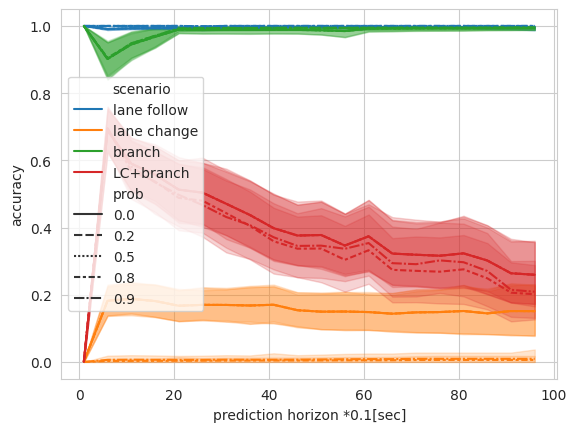

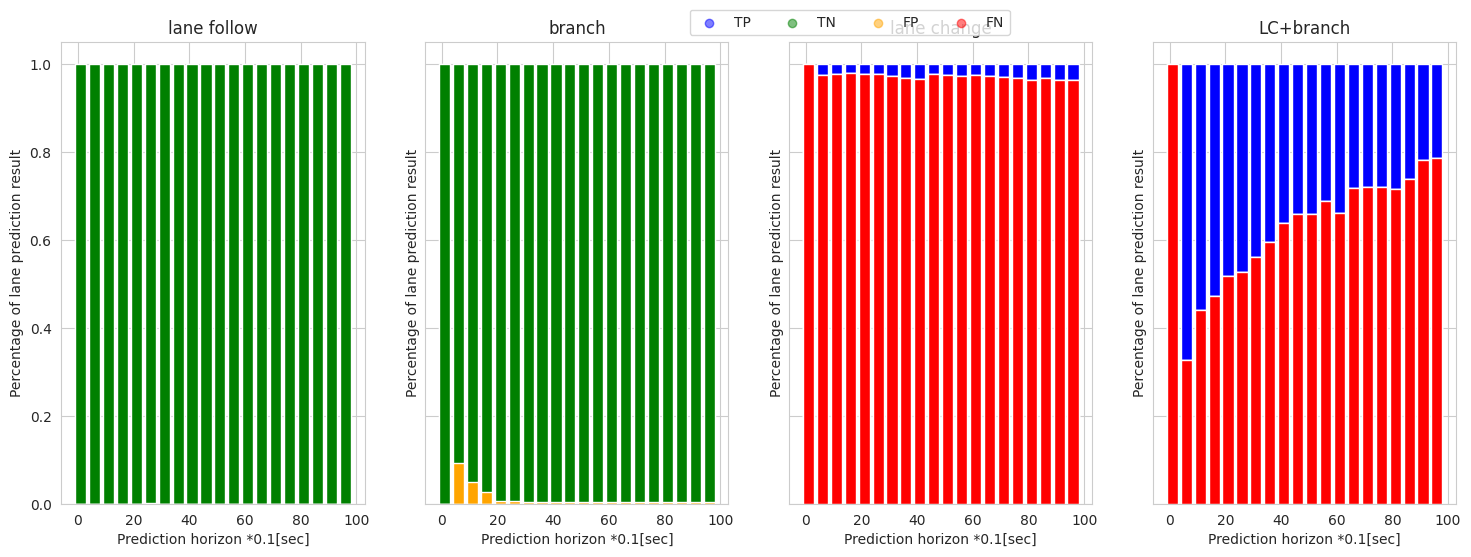

In [90]:
sns.set_style("whitegrid")
hue_order = ["lane follow", "lane change", "branch", "LC+branch"]

visualize_data = lane_prediction_df[lane_prediction_df.is_selected==True]
# fig, ax = plt.subplots()
# for id in visualize_data["id"].drop_duplicates():
#     sns.lineplot(data=visualize_data[visualize_data.id==id], x="horizon", y="acc", ax=ax)
# ax.set_xlabel("prediction horizon *0.1[sec]")
# ax.set_ylabel("accuracy")
# plt.savefig("acc_lineplot_horizon_interval_5.svg")

# fig, ax = plt.subplots(1,2, figsize=(12,6), sharey = "all", tight_layout=True)
fig, ax = plt.subplots()
sns.lineplot(data=lane_prediction_df, x="horizon", y="acc", hue="scenario", style="prob", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("accuracy")
plt.savefig("acc_lineplot_horizon_all_interval_5.svg")

fig, ax = plt.subplots(1, len(visualize_data.scenario.drop_duplicates()), figsize=(18,6), sharey = "all")
for i, scenario in enumerate(visualize_data.scenario.drop_duplicates()):
    for horizon in visualize_data.horizon.drop_duplicates():

        target_df = visualize_data[(visualize_data.horizon == horizon) & (visualize_data.scenario == scenario)]
        TN = (target_df.TN + target_df.FP + target_df.FN) / target_df.num
        FP = (target_df.FP + target_df.FN) / target_df.num
        FN = (target_df.FN) / target_df.num
        # scenario_index = [key for key in scenario_id_name.items() if value == scenario][0]
        ax[i].bar(horizon, 1.0, color="blue", width=4)
        ax[i].bar(horizon, TN.mean(), color="green", width=4)
        ax[i].bar(horizon, FP.mean(), color="orange", width=4)
        ax[i].bar(horizon, FN.mean(), color="red", width=4)
        ax[i].set_xlabel("Prediction horizon *0.1[sec]")
        ax[i].set_ylabel("Percentage of lane prediction result")
    ax[i].set_title(scenario)
    
plt.scatter([], [], c="blue", alpha=0.5, label="TP")
plt.scatter([], [], c="green", alpha=0.5, label="TN")
plt.scatter([], [], c="orange", alpha=0.5, label="FP")
plt.scatter([], [], c="red", alpha=0.5, label="FN")
plt.legend(loc="lower center", bbox_to_anchor=(-1, 1.0), ncol=4)
plt.savefig("acc_bar_interval_5.svg")
plt.show()

In [67]:
# visualize_data = result
visualize_data = result[result.is_selected]

# # select minimum ADE trajectory
# visualize_data = pd.DataFrame([], columns=result.columns)
# result_wo_na = result.dropna()
# for id in tqdm.tqdm(result_wo_na.id.drop_duplicates()):
#     for horizon in result_wo_na[(result_wo_na.id == id)].horizon.drop_duplicates():
#         for t in result_wo_na[(result_wo_na.id == id) & (result_wo_na.horizon == horizon)].t.drop_duplicates():
#             buf_data = result_wo_na[(result_wo_na.id == id) & (result_wo_na.horizon == horizon) & (result_wo_na.t == t)]
#             if buf_data.empty: continue
#             try:
#                 buf_data_idx = buf_data.ADE_lat.idxmin()
#                 target_s = result_wo_na.iloc[buf_data_idx]
#                 visualize_data.loc[target_s.name] = target_s.values
#             except:
#                 print(buf_data_idx)
suffix = "_selected"

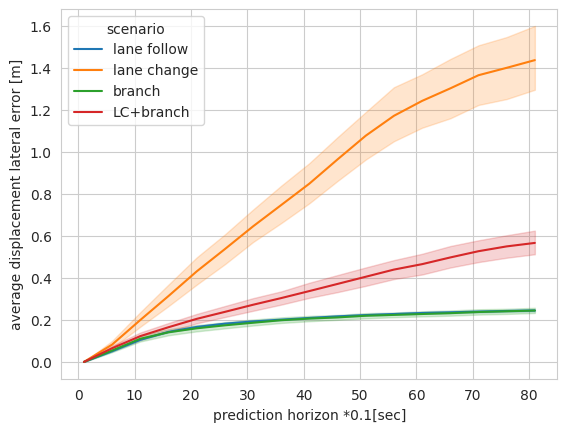

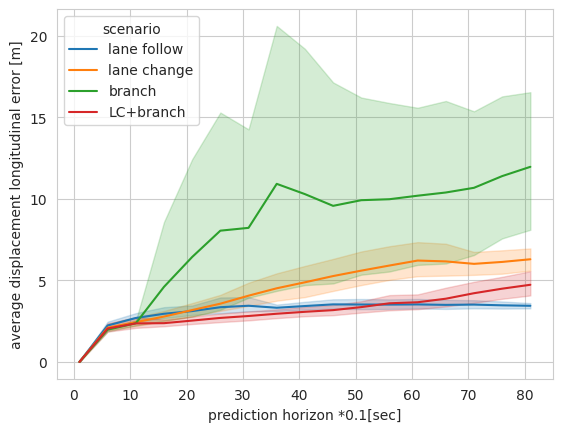

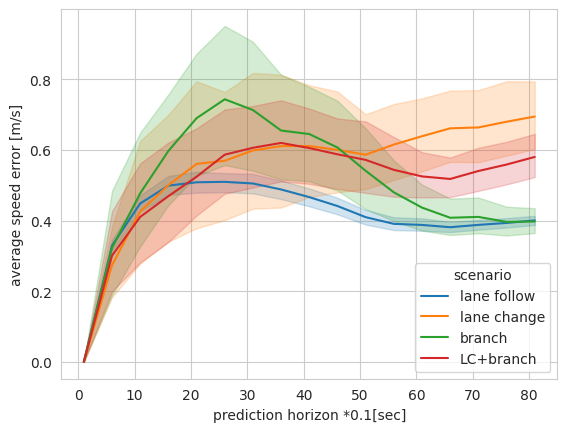

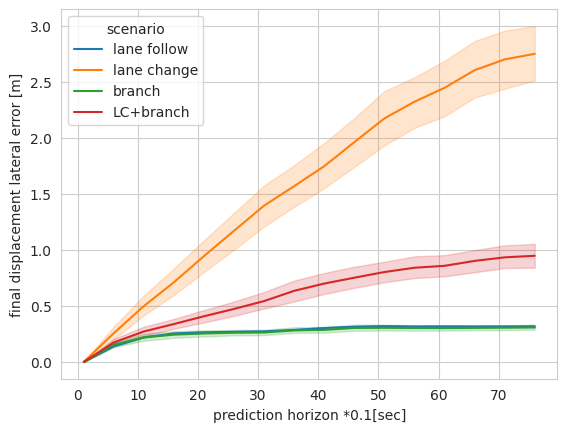

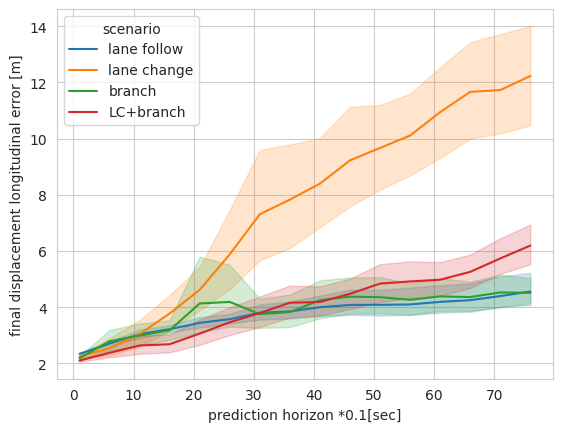

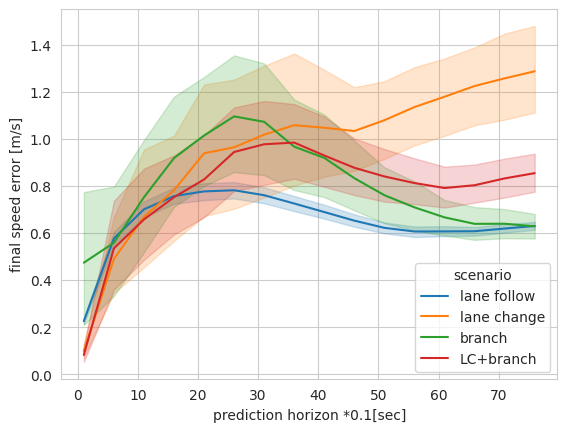

In [68]:
sns.set_style("whitegrid")
hue_order = ["lane follow", "lane change", "branch", "LC+branch"]

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="ADE_lat", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("average displacement lateral error [m]")
plt.savefig(f"ADE_lateral{suffix}.svg")

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="ADE_long", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("average displacement longitudinal error [m]")
plt.savefig(f"ADE_longitudinal{suffix}.svg")

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="ADE_speed", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("average speed error [m/s]")
plt.savefig(f"ADE_speed{suffix}.svg")

# fig, ax = plt.subplots(1,2, figsize=(12,6), sharey = "all", tight_layout=True)
# sns.lineplot(data=visualize_data, x="horizon", y="FDE", hue="is_lane_change", ax=ax[0])
# ax[0].set_xlabel("prediction horizon *0.1[sec]")
# ax[0].set_ylabel("final displacement error [m]")

# sns.lineplot(data=visualize_data, x="horizon", y="FDE", hue="is_branch", ax=ax[1])
# ax[1].set_xlabel("prediction horizon *0.1[sec]")
# ax[1].set_ylabel("final displacement error [m]")
# plt.savefig(f"FDE{suffix}.svg")

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="FDE_lat", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("final displacement lateral error [m]")
plt.savefig(f"FDE_lateral{suffix}.svg")

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="FDE_long", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("final displacement longitudinal error [m]")
plt.savefig(f"FDE_longitudinal{suffix}.svg")

fig, ax = plt.subplots()
sns.lineplot(data=visualize_data, x="horizon", y="FDE_speed", hue="scenario", ax=ax, hue_order=hue_order)
ax.set_xlabel("prediction horizon *0.1[sec]")
ax.set_ylabel("final speed error [m/s]")
plt.savefig(f"FDE_speed{suffix}.svg")

In [63]:
with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact.pkl", mode='wb') as f:
    pickle.dump(prediction_data,f)
    
with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact_result.pkl", mode='wb') as f:
    pickle.dump(result,f)

with open("/home/kuribayashi-a/Downloads/20250519-104336.00005.compact_lane_prediction.pkl", mode='wb') as f:
    pickle.dump(lane_prediction_df,f)

In [69]:
def draw_map(ax, path, map, color):
    # extract lane id from path
    draw_id_list = []
    for lane_ids in path:
        for lane_id in lane_ids:
            draw_id_list.append(lane_id)
    draw_id_list = set(draw_id_list)

    for lane_id in draw_id_list:
        lane_data = map.iloc[int(np.where(map.lane_id==str(lane_id))[0][0])]
        # draw lane, right lane, left lane
        for id in [lane_id, lane_data.left_neighbor_lane_id, lane_data.right_neighbor_lane_id]:
            if id != "":
                geometry = map.iloc[int(np.where(map.lane_id==str(id))[0][0])].geometry
                gpd.GeoSeries(geometry).plot(ax=ax, color=color, alpha=0.2)


In [70]:
def draw_selected_map(ax, path, map, color):
    # extract lane id from path
    draw_id_list = []
    for lane_ids in path:
        for lane_id in lane_ids:
            draw_id_list.append(lane_id)
    draw_id_list = set(draw_id_list)

    for lane_id in draw_id_list:
        lane_data = map.iloc[int(np.where(map.lane_id==str(lane_id))[0][0])]
        # draw lane, right lane, left lane
        geometry = map.iloc[int(np.where(map.lane_id==str(lane_id))[0][0])].geometry
        gpd.GeoSeries(geometry).plot(ax=ax, color=color)


In [71]:
def draw_line(ax, points, color, label, style):
    line_coords = []
    for point in points:
    # Define coordinates for a simple line
        line_coords.append((point[0], point[1]))

    # Create a LineString geometry
    line_geometry = LineString(line_coords)
    point_geometry = []
    for p in points:
        point_geometry.append(Point((p[0], p[1])))
    # Create a GeoDataFrame
    gdf_line = gpd.GeoDataFrame(geometry=[line_geometry, *point_geometry])
    gdf_line.plot(color=color, ax=ax, label=label, linestyle=style, markersize=10)

    # Create start point
   

In [116]:
result[result.FDE_speed>20.0] 

,id,t,horizon,is_lane_change,is_branch,scenario,pred_lane_change,prob,is_selected,ADE_lat,ADE_long,ADE_speed,FDE_lat,FDE_long,FDE_speed
0,2727,1.0,1.0,False,False,0,False,0.914887,True,5.670116e-07,0.000045,43.541611,0.034857,0.008710,43.488909
1,2727,6.0,1.0,False,False,0,False,0.918414,True,1.915233e-07,0.000113,43.775291,0.008090,0.022607,43.779303
2,2727,11.0,1.0,False,False,0,False,0.920015,True,1.570086e-06,0.000217,44.079120,0.011257,0.017611,44.015960
3,2727,16.0,1.0,False,False,0,False,0.925255,True,0.000000e+00,0.000000,44.142592,0.045682,0.005876,44.178288
4,2727,21.0,1.0,False,False,0,False,0.927836,True,1.453490e-07,0.000277,44.439226,0.113396,0.006622,44.407837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200215,3727,6.0,1.0,False,False,0,False,0.938827,True,4.304316e-05,0.001941,59.562984,0.018597,0.024384,59.491583
200216,3727,1.0,6.0,False,False,0,False,0.942271,True,1.445959e-02,0.635061,62.640374,0.061180,1.794260,62.456761
200217,3728,1.0,1.0,False,False,0,False,0.908983,True,3.026463e-05,0.001185,55.732822,0.160075,0.226825,55.628220
200218,3728,6.0,1.0,False,False,0,False,0.925229,True,5.853577e-07,0.000518,52.004746,0.096930,0.068272,52.036419


In [78]:
result[(result.is_lane_change!=result.pred_lane_change)]

,id,t,horizon,is_lane_change,is_branch,scenario,pred_lane_change,prob,is_selected,ADE_lat,ADE_long,ADE_speed,FDE_lat,FDE_long,FDE_speed,dist_to_ego
150,2771,10.0,1.0,True,False,lane change,False,0.931316,True,0.000000,7.566996e-10,0.000000,3.346506e-07,1.798468,0.048310,3.936935e+06
151,2771,10.0,1.0,True,False,lane change,False,0.683322,False,0.000000,7.566996e-10,0.000000,6.554251e-04,1.815414,0.033853,3.936935e+06
152,2771,15.0,1.0,True,False,lane change,False,0.923232,True,0.000000,2.328306e-10,0.000000,4.585535e-10,1.801885,0.016550,3.936936e+06
153,2771,15.0,1.0,True,False,lane change,False,0.632119,False,0.000000,2.328306e-10,0.000000,2.052027e-05,1.798288,0.007160,3.936936e+06
155,2771,30.0,1.0,True,True,LC+branch,False,0.913316,True,0.000000,1.746230e-10,0.000000,9.378382e-06,1.783251,0.025098,3.936937e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200963,3721,10.0,6.0,False,False,lane follow,True,0.637006,False,0.064648,1.415661e+00,0.921364,5.744331e-02,0.230300,2.762612,3.931312e+06
200965,3721,5.0,11.0,False,False,lane follow,True,0.501410,False,0.131092,3.754300e+00,2.407800,3.859074e-01,3.744653,0.060412,3.931300e+06
200966,3721,10.0,11.0,True,False,lane change,False,0.806924,True,0.083705,1.165257e+00,1.370591,2.194988e-01,1.346795,2.466907,3.931312e+06
200969,3721,5.0,16.0,True,False,lane change,False,0.877181,True,0.074745,4.083871e+00,2.703340,1.386786e-01,6.044022,4.814268,3.931300e+06


In [83]:
prev_id = None

for index, row in result.iterrows():
    if row.pred_lane_change != row.is_lane_change \
       and row.horizon==61.0 \
       and row.id != prev_id \
       and row.is_branch:

    
    # if r.horizon == 61.0 and r.is_lane_change != r.pred_lane_change and r.is_branch == False and r.is_selected:
        time = row.t
        
        draw_data = prediction_data[id]
        # draw_horizon = min(61, result[result.id==id].horizon.max())
        draw_result = result[(result.id==id) & (result.t==time) & (result.is_selected==True) & (result.horizon==draw_horizon)]
        if draw_result.empty: continue
        # print(id, time, draw_horizon, draw_result)
        fig, ax = plt.subplots(figsize=(12,6))
        
        draw_selected_map(ax, draw_data["path_lane_id"][int(time):int(time)+int(draw_horizon)], map, "gray")
        
        for j in range(0, len(draw_data["pred_lane_id"][int(time)])):
            draw_selected_map(ax, draw_data["pred_lane_id"][int(time)][0:int(draw_horizon)][j], map, "green")
            draw_line(ax, draw_data["pred"][int(time)][j][0:int(draw_horizon)], "red" if draw_data["prob"][int(time)][j] == draw_result.prob.iloc[-1] else "gray", "prediction", "-")

        draw_line(ax, draw_data["path"][int(time):int(time)+int(draw_horizon)], "blue", "path", "-")
        
        ax.text(0.5, 1.05, f"id: {row.id} | t: {time}\n FDE_lateral: {draw_result.FDE_lat.iloc[-1]} \n FDE_longitudinal: {draw_result.FDE_long.iloc[-1]}", ha='center', transform=ax.transAxes)

        plt.legend()
        plt.show()
        prev_id = row.id
    

# Visualize the sequence of the prediction

In [ ]:
# for id in result.id.drop_duplicates():
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

id = 2771
is_drawn = any(
    result[(result.id == id)].apply(lambda row: row.pred_lane_change != row.is_lane_change, axis=1)
)
# if not is_drawn:
#     continue

draw_data = prediction_data[id]
draw_horizon = min(61, result[result.id == id].horizon.max())
times = result[(result.id == id)].t.drop_duplicates()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Set up writer for this id
output_file = f"lane_change_{id}.mp4"
writer = FFMpegWriter(fps=2, metadata=dict(artist='AutoGen'), bitrate=1800)

with writer.saving(fig, output_file, dpi=100):
    for time in range(0, int(times.max())):
        print(time, id)
        ax.clear()
        # Draw lane/path
        draw_selected_map(ax,
                          draw_data["path_lane_id"][int(time):int(time)+int(draw_horizon)],
                          map, "gray")

        for j in range(len(draw_data["pred_lane_id"][int(time)])):
            draw_selected_map(ax,
                              draw_data["pred_lane_id"][int(time)][0:int(draw_horizon)][j],
                              map, "green")
            draw_line(ax,
                      draw_data["pred"][int(time)][j][0:int(draw_horizon)],
                      "red" if draw_data["prob"][int(time)][j] == max(draw_data["prob"][int(time)]) else "gray",
                      "prediction", "-")

        draw_line(ax,
                  draw_data["path"][int(time):int(time)+int(draw_horizon)],
                  "blue", "path", "-")


        draw_result = result[(result.id == id) &
                 (result.t == time) &
                 (result.is_selected == True) &
                 (result.horizon == draw_horizon)]
        
        ax.legend()

        if not draw_result.empty:
            ax.text(0.5, 1.05,
                f"ID: {id} | t: {time}\nFDE_lat: {draw_result.FDE_lat.iloc[-1]:.2f} | FDE_long: {draw_result.ADE_lat.iloc[-1]:.2f}",
                ha='center', transform=ax.transAxes)
            for i in range(0, 5):
                writer.grab_frame()
        else:
            ax.text(0.5, 1.05,
                f"ID: {id} | t: {time}\nFDE_lat: -- | FDE_long: --",
                ha='center', transform=ax.transAxes)  

            writer.grab_frame()
        

plt.close(fig)
print(f"Saved animation for ID {id} -> {output_file}")
